In [810]:
from qiskit import *
import numpy as np

from qiskit.visualization import plot_histogram
from qiskit import IBMQ, Aer
from scipy.optimize import minimize
from qiskit.providers.fake_provider import FakeToronto, FakeTorontoV2
import time

import matplotlib.pyplot as plt
%matplotlib inline

provider=IBMQ.load_account()
times = {
    "rx": {
        3: [],
        4: [],
        5: [],
        6: [],
    },
    "had": {
        3: [],
        4: [],
        5: [],
        6: [],
    }
}

ibmqfactory.load_account:WARNING:2022-12-05 05:41:41,766: Credentials are already in use. The existing account in the session will be replaced.


In [811]:
# These functions build and return a quantum circuit for a given graph
# connections is a list of edge connections

def QAOA_Vertex_Cover(connections,gamma,beta):
    n=max(map(max, connections))+1
    qc=QuantumCircuit(n+1,n)


    qc.x(n)
    qc.h(range(n))
    
    
    qc.barrier()
    for i in connections:
        qc.cp(-1*gamma,i,n)
        qc.mcp(gamma,i,n)

        
    qc.barrier()


    for i in range(n):
        qc.x(i)
        qc.cp(-1*gamma,i,n)
        qc.x(i)


    qc.barrier()


    qc.rx(2*beta, range(n))


    qc.measure(range(n),range(n))

    return qc

# same as above, but returns circuit with second mixer. namely, hadamard mixer
def QAOA_Vertex_Cover_had(connections,gamma,beta):
    n=max(map(max, connections))+1
    qc=QuantumCircuit(n+1,n)


    qc.x(n)
    qc.h(range(n))
    
    
    qc.barrier()
    for i in connections:
        qc.cp(-1*gamma,i,n)
        qc.mcp(gamma,i,n)

        
    qc.barrier()


    for i in range(n):
        qc.x(i)
        qc.cp(-1*gamma,i,n)
        qc.x(i)


    qc.barrier()


    qc.rx(2/np.sqrt(2)*beta, range(n))
    qc.rz(2/np.sqrt(2)*beta, range(n))


    qc.measure(range(n),range(n))

    return qc




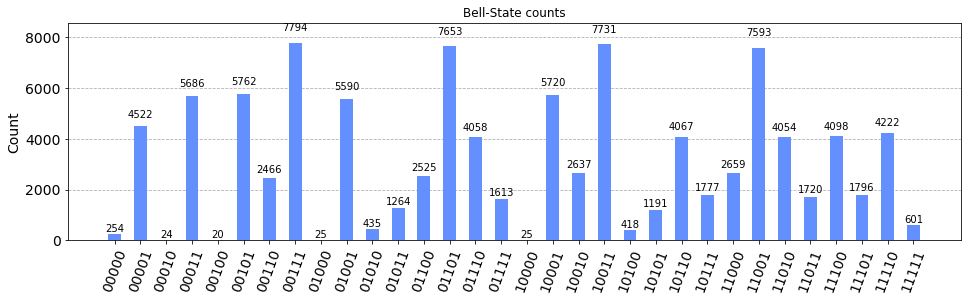

In [812]:
# this block contains an example of running the QAOA circuit on graph with 5 nodes
connections=[[0,1],[0,2],[0,3],[0,4],[1,3],[2,4]]

gamma=np.pi*7/4
beta=np.pi*3.5/4
qc=QAOA_Vertex_Cover(connections,gamma,beta)

qc.draw()

backend = Aer.get_backend('aer_simulator')
circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, title='Bell-State counts',figsize=(16,4))

In [813]:
# class for making, storing, transforming, and accessing graph
class graph:
    def __init__(self, _graph=None):
        if _graph is None:
            _graph = {}
        self._graph = _graph
      
    def getVertices(self):
        return list(self._graph.keys())
    
    def printVertices(self):
        print(self.getVertices())
    
    def getEdges(self):
        edgename = []
        for vrtx in self._graph:
            for nxtvrtx in self._graph[vrtx]:
                if {nxtvrtx, vrtx} not in edgename:
                    edgename.append({vrtx, nxtvrtx})
        ret_list = []
        for i in range(len(edgename)):
            ret_list.append([])
            for j in edgename[i]:
                ret_list[i].append(j)
        return ret_list
    
    def printEdges(self):
        print(self.getEdges())
        
    def getGraph(self):
        return self._graph
    
    def make_graph_from_connections(self, connections):
        vertexs = []
        graph_dict = {}
        for edge_list in connections:
            for vertex in edge_list:
                if vertex not in vertexs:
                    vertexs.append(vertex)
                    
        for vertex in vertexs:
            graph_dict[vertex] = []
            
        for edge_list in connections:
            if edge_list[1] not in graph_dict[edge_list[0]]:
                graph_dict[edge_list[0]].append(edge_list[1])
                
            if edge_list[0] not in graph_dict[edge_list[1]]:
                graph_dict[edge_list[1]].append(edge_list[0])
                
        self._graph = graph_dict
        
    def printGraph(self):
        print(self._graph)
          
    

In [814]:
# this block contains examples of how to use graph class
g = graph()
g.make_graph_from_connections(connections)
g.printEdges()
g.printVertices()
g.printGraph()

[[0, 1], [0, 2], [0, 3], [0, 4], [1, 3], [2, 4]]
[0, 1, 2, 3, 4]
{0: [1, 2, 3, 4], 1: [0, 3], 2: [0, 4], 3: [0, 1], 4: [0, 2]}


In [815]:
# objective function. returns an objective score for the a given vertex cover and graph, the objective score will
# be more negative the closer the cover is to a minimum vertex cover. this is the value that will we try to minimize in the
# optimization process
def mvc_obj(bitstring, graph):
    obj1 = 0
    obj2 = 0
    
    for i in range(len(bitstring)):
        if bitstring[i] == '0':
            obj1 -= 1
    
    connections = graph.getEdges()
    for vtx in connections:
        if bitstring[vtx[0]] == '1' or bitstring[vtx[1]] == '1':
            obj2 -= 1
        
    #return obj1 + (obj2*1.2)
    return obj1 + obj2

# computes the expectation value of the problem hamiltonian. using the objective value from each possible vertex cover from 
# the counts from running the circuit
def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = mvc_obj(bitstring[::-1], graph)
        avg += obj*count
        sum_count += count
    
    return avg/sum_count

# returns a function that computes the expectation value for each possible vertex cover for a graph. this returned function is used in the
# optimization function
def get_expectation(graph, backend, shots=100000):
    #simulator = Aer.get_backend('aer_simulator')
    backend.shots = shots
    connections = graph.getEdges()
            
    def execute_circ(theta):
        
        qc = QAOA_Vertex_Cover(connections,theta[0],theta[1])
        circ = transpile(qc, backend)
        res = backend.run(circ, shots).result()
        #rx_times.append(res.time_taken())
        counts = res.get_counts()
        
        return compute_expectation(counts, graph)
    
    return execute_circ

# same as function above, but returns function for hadamard mixer
def get_expectation_had(graph, backend, shots=100000):
    #simulator = Aer.get_backend('aer_simulator')
    backend.shots = shots
    connections = graph.getEdges()
            
    def execute_circ_had(theta):
        
        qc = QAOA_Vertex_Cover_had(connections,theta[0],theta[1])
        circ = transpile(qc, backend)
        res = backend.run(circ, shots).result()
        #ry_times.append(res.time_taken())
        counts = res.get_counts()
        
        return compute_expectation(counts, graph)
    
    return execute_circ_had
    

# Testing on aer_simulator backend

In [816]:
backend = Aer.get_backend('aer_simulator')

# Rx Mixer

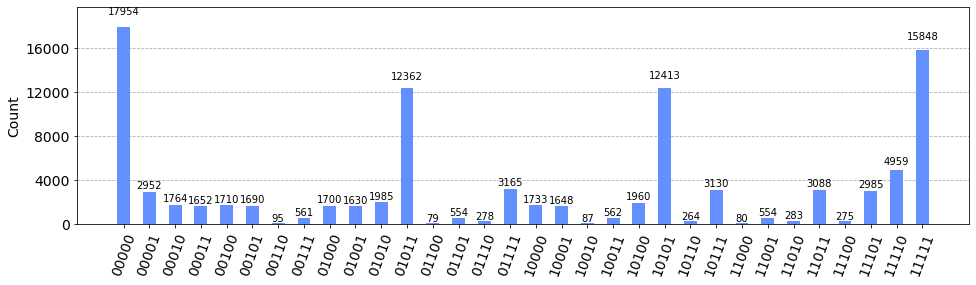

In [817]:
# 5 qubits
gamma=5
beta=2
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 6.780966542275031 ,Beta Pre-Otimization: 2 ,Beta Post-Optimization: 3.624716220498223


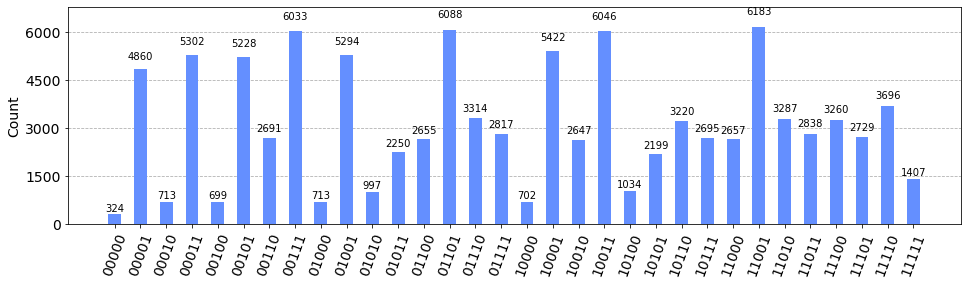

In [818]:
# 5 qubits

gamma=5
beta=2
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
#times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

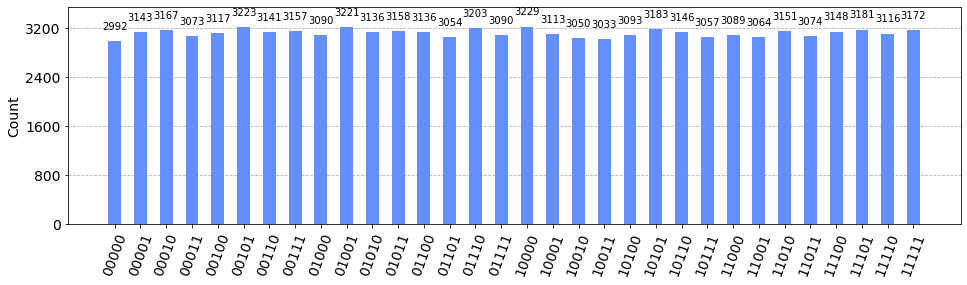

In [819]:
# 5 qubits

gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: 1.7292912276916934 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: -1.2860067861381606


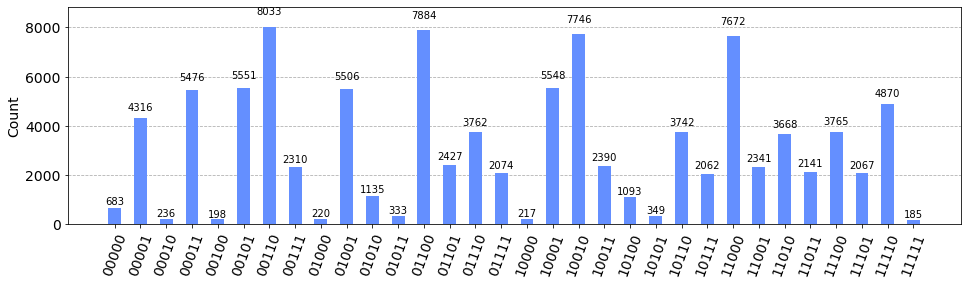

In [820]:
# 5 qubits
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [821]:
graph2_dict = {
    0: [2,4],
    1: [2],
    2: [0,1,3],
    3: [2],
    4: [0]
}
g2 = graph(graph2_dict)
print(g2.getEdges())

[[0, 2], [0, 4], [1, 2], [2, 3]]


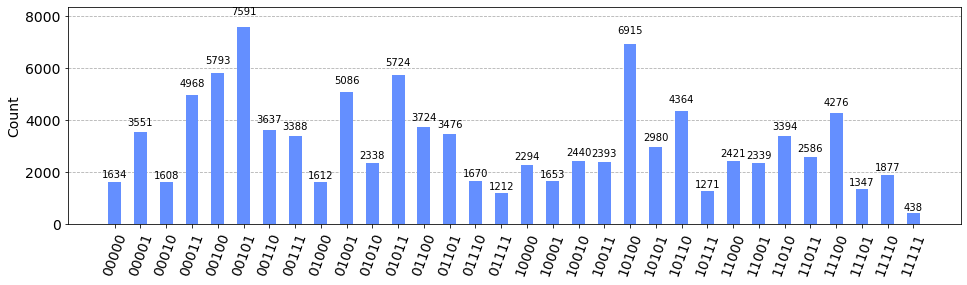

In [822]:
# 5 qubits
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g2.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.73515133229298 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.628540200766695


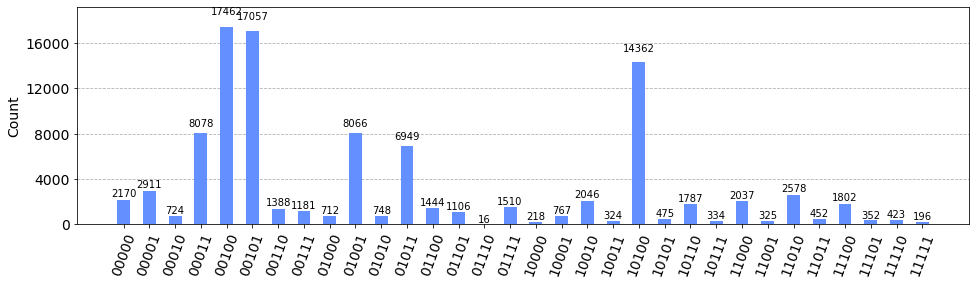

In [823]:
# 5 qubits
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g2, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g2.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
#times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [824]:
graph3_dict = {
    0: [1,2],
    1: [0],
    2: [0,3],
    3: [2],
}
g3 = graph(graph3_dict)
print(g3.getEdges())

[[0, 1], [0, 2], [2, 3]]


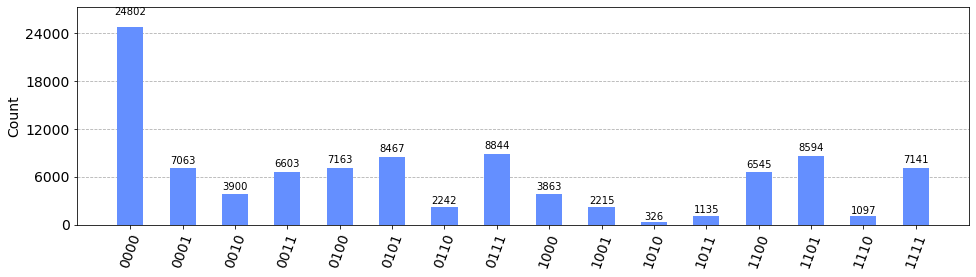

In [825]:
# 4 qubits
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.9520423455456877 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.9082064549651545


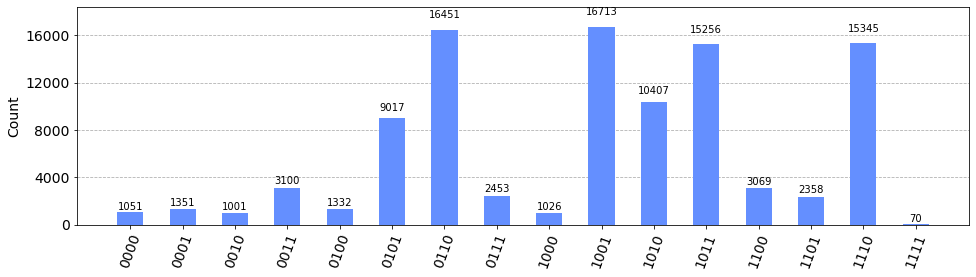

In [826]:
# 4 qubits
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [827]:
graph4_dict = {
    0: [3],
    1: [4],
    2: [5],
    3: [0,4],
    4: [1,3,5],
    5: [2,4]
}
g4 = graph(graph4_dict)
print(g4.getEdges())

[[0, 3], [1, 4], [2, 5], [3, 4], [4, 5]]


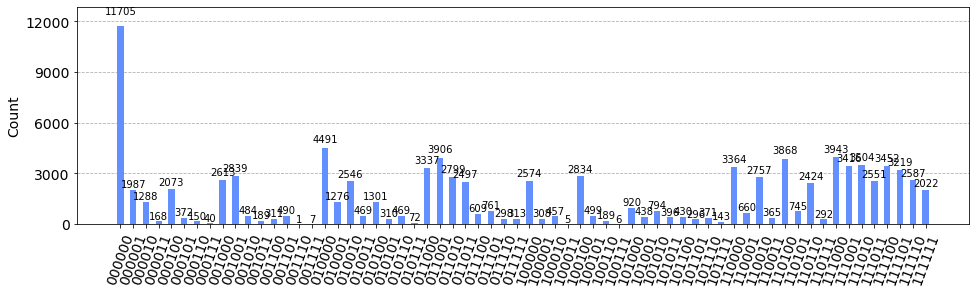

In [828]:
# 6 qubits
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.0398914562936055 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.9751171283275955


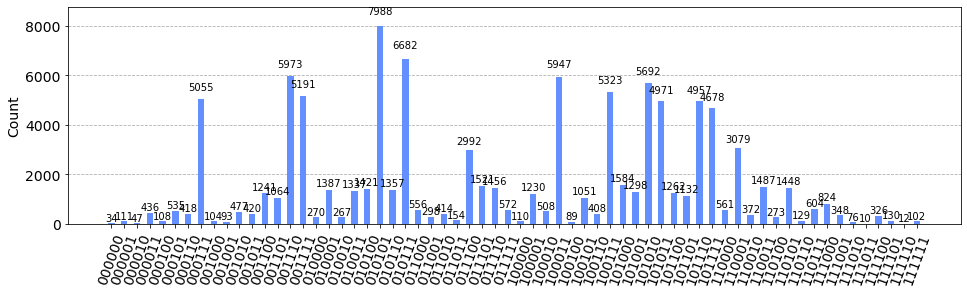

In [829]:
# 6 qubits
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

In [830]:
graph5_dict = {
    0: [1],
    1: [0,2],
    2: [1],
}
g5 = graph(graph5_dict)
print(g5.getEdges())

[[0, 1], [1, 2]]


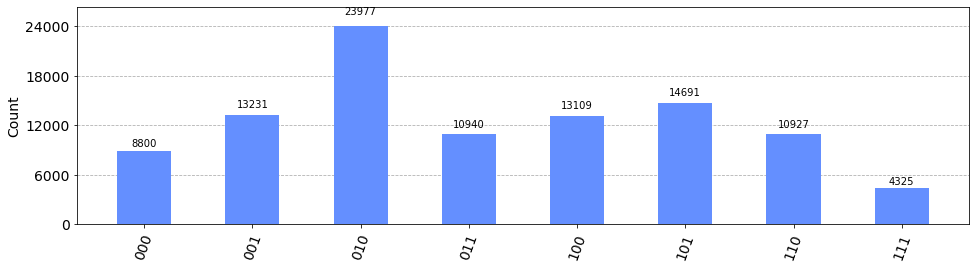

In [831]:

# 3 qubits
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.651307988535998 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.6288933138692014


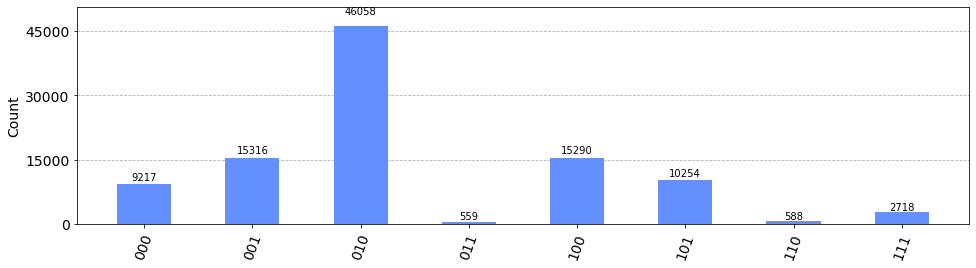

In [832]:
# 3 qubits

gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

# Hadamard Mixer

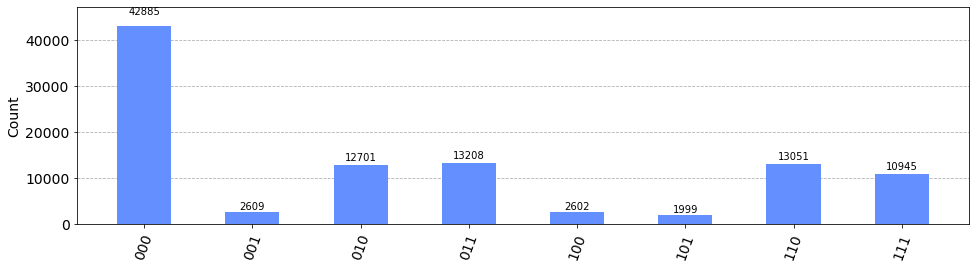

In [833]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.741985112945892 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 3.8821033336295834


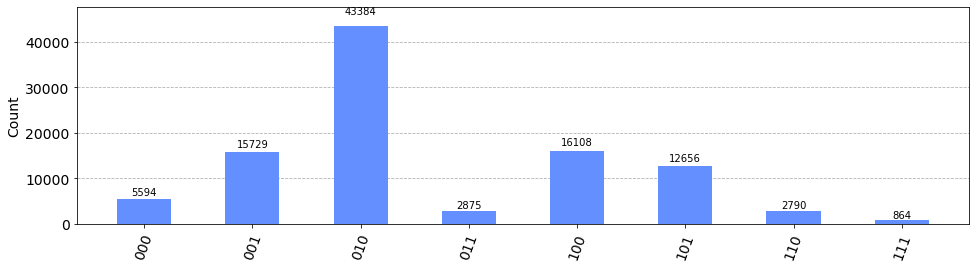

In [834]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation_had(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

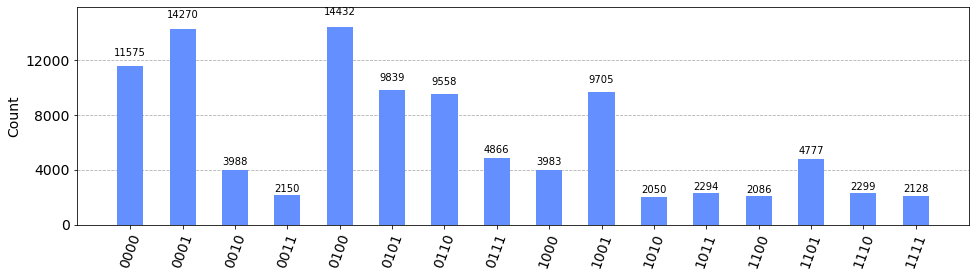

In [835]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

{0: [1, 2], 1: [0], 2: [0, 3], 3: [2]}
Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.2596674110084047 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 0.5830796515461917


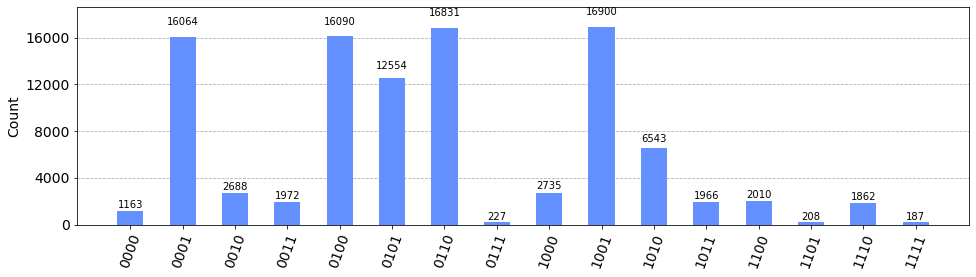

In [836]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g3, backend)
g3.printGraph()

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

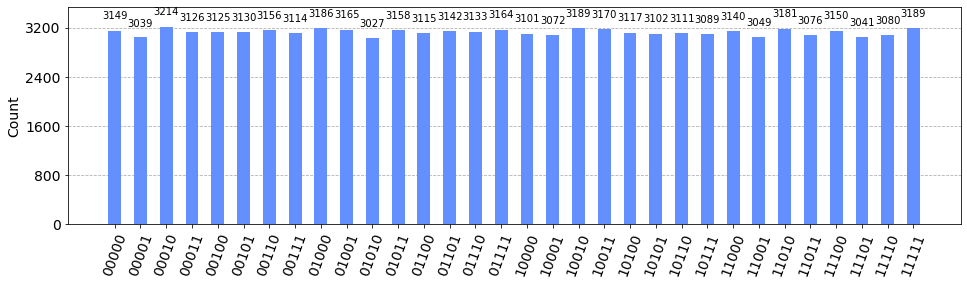

In [837]:
# 5 qubit
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: -0.9211152928270145 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: -0.5783207011153823


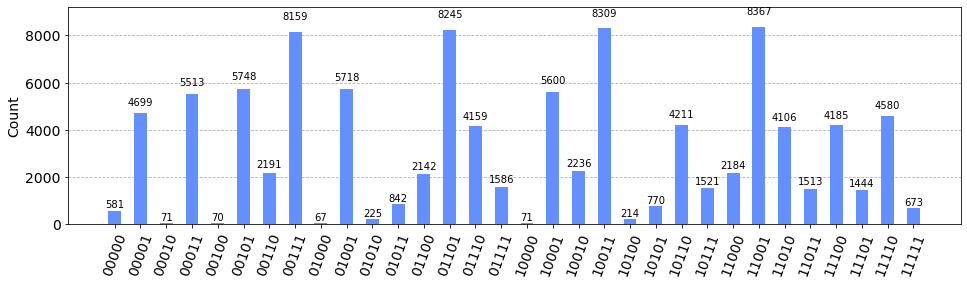

In [838]:
# 5 qubits
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation_had(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

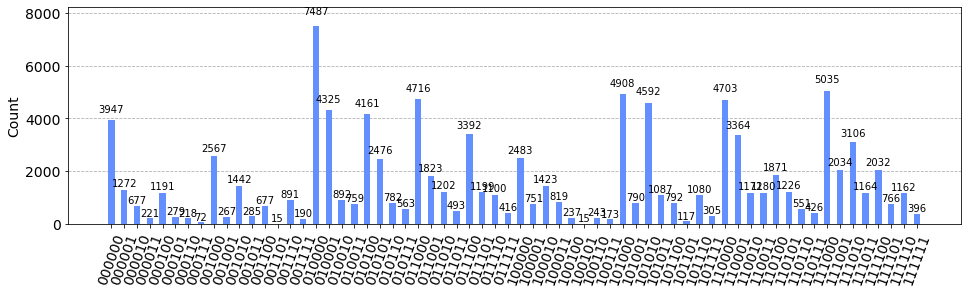

In [839]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.2488855004222448 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 0.6635067914393031


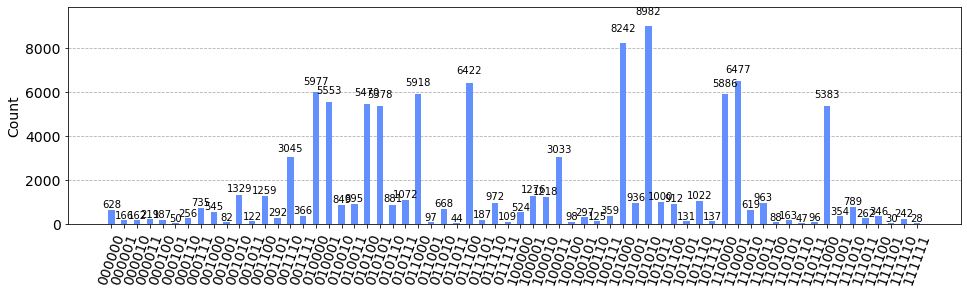

In [840]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

# Testing on fake noisy backend

In [841]:
simulator = FakeToronto()

# Rx Mixer

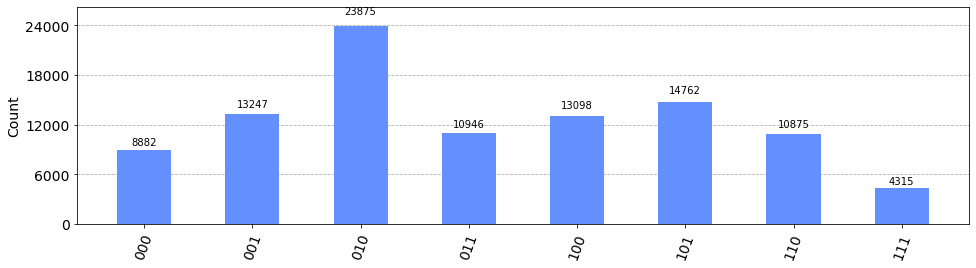

In [842]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.643873611334652 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.6088969420903028


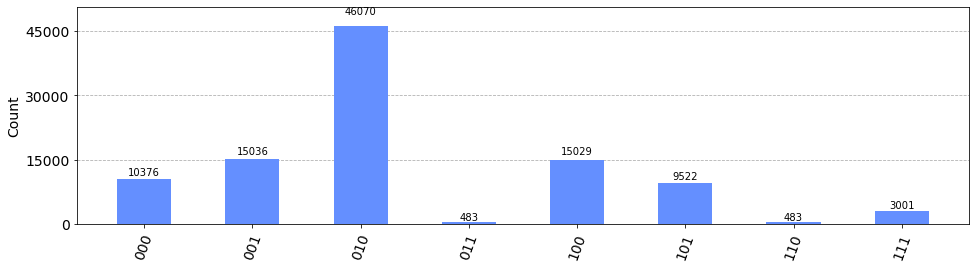

In [843]:
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

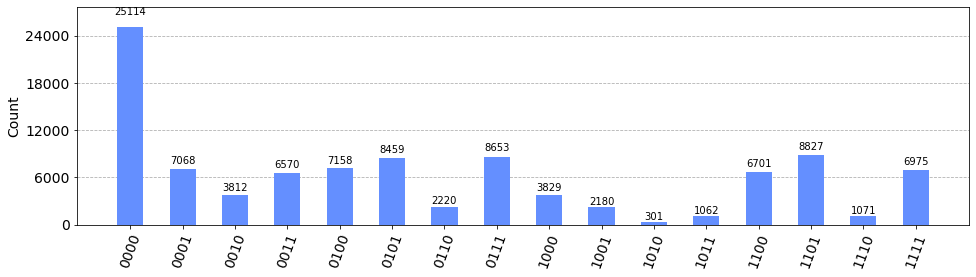

In [844]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 0.9531228310377292 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.9965144782340365


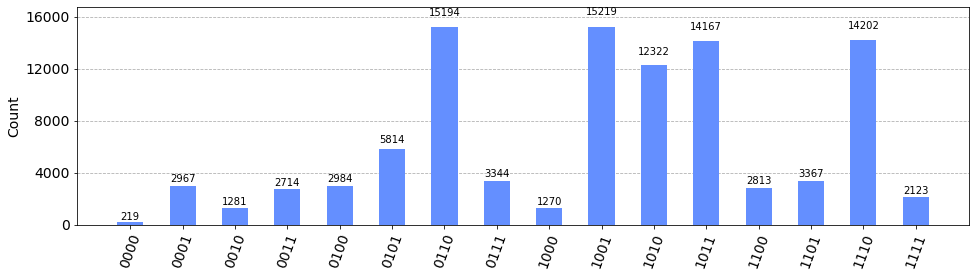

In [845]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

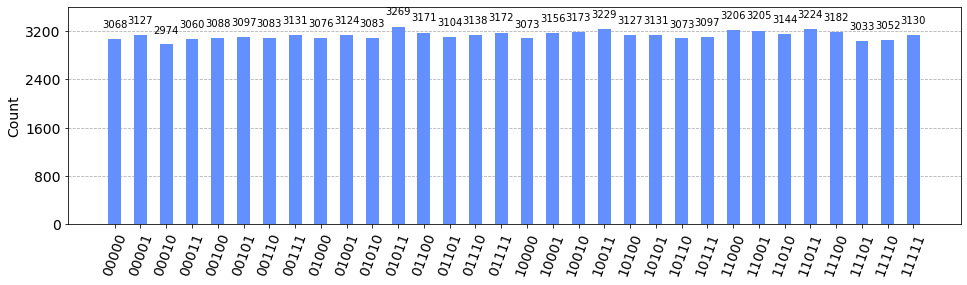

In [846]:
# 5 qubit
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.1781023830679553 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.88144625813555


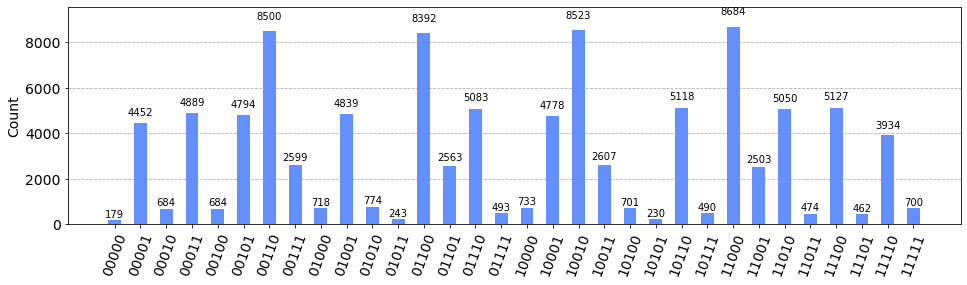

In [847]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

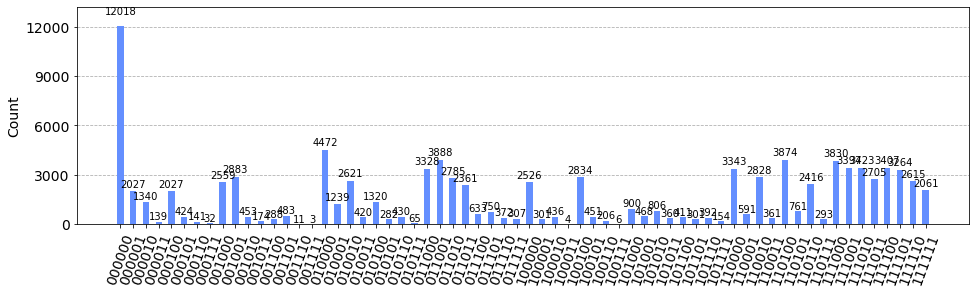

In [848]:
# 6 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.935723589940355 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.8850902125723592


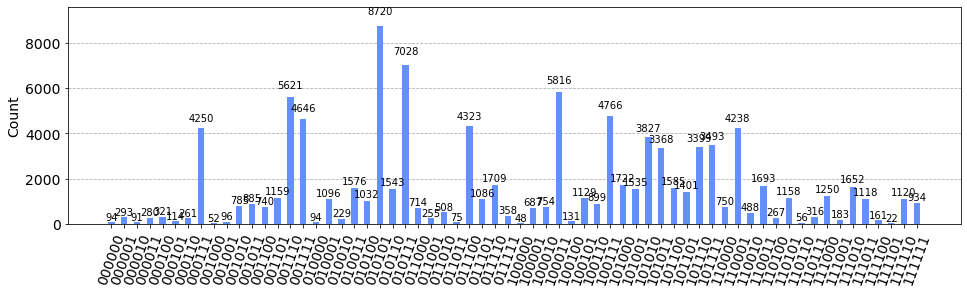

In [849]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

# Hadamard Mixer

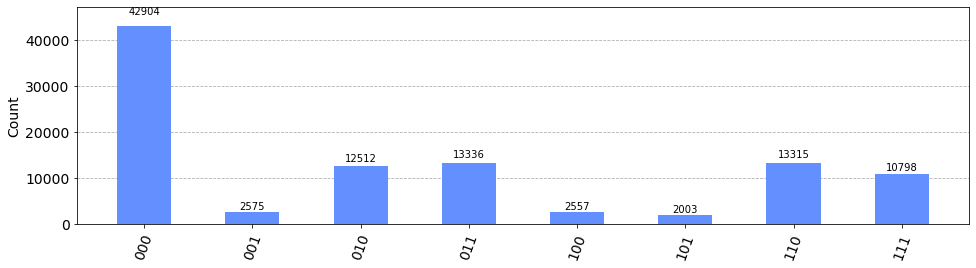

In [850]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.760187311173529 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 3.7176596767309293


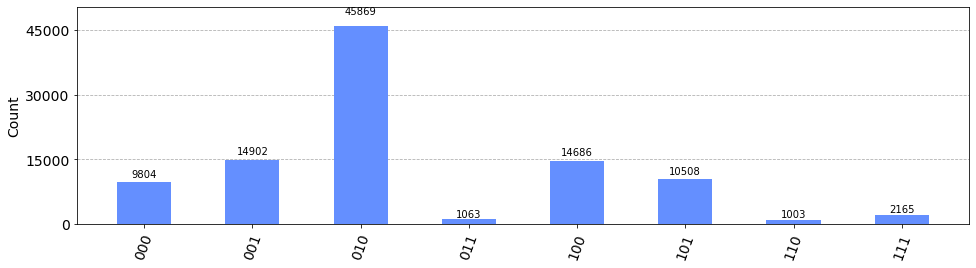

In [851]:
# 3 qubits
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation_had(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

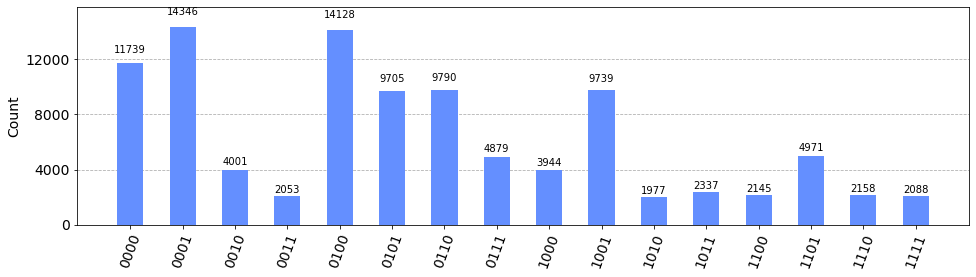

In [852]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.988762641172938 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 0.6446419870334021


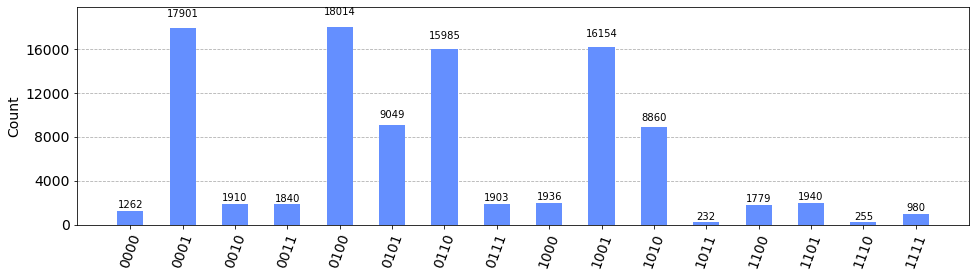

In [853]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

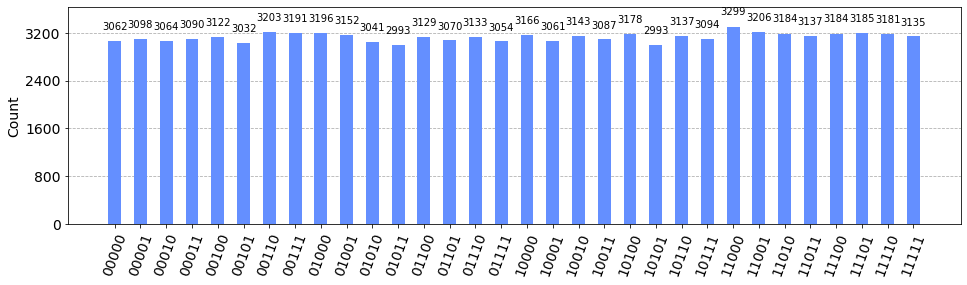

In [854]:
# 5 qubit
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 5.229218482276965 ,Beta Pre-Otimization: 2 ,Beta Post-Optimization: 1.7040766890373782


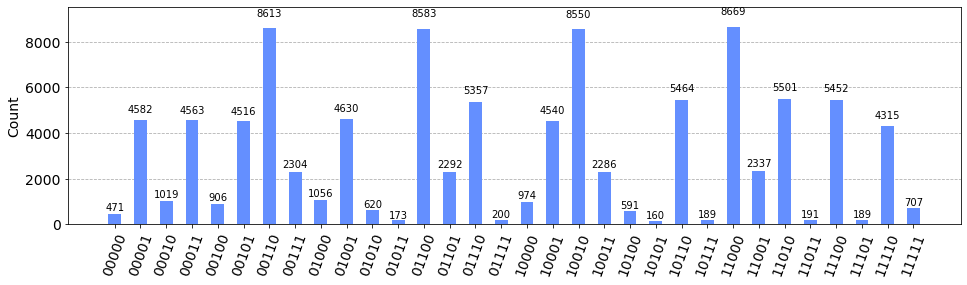

In [855]:
# 5 qubits
gamma=5
beta=2
theta = [gamma, beta]
expectation = get_expectation_had(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

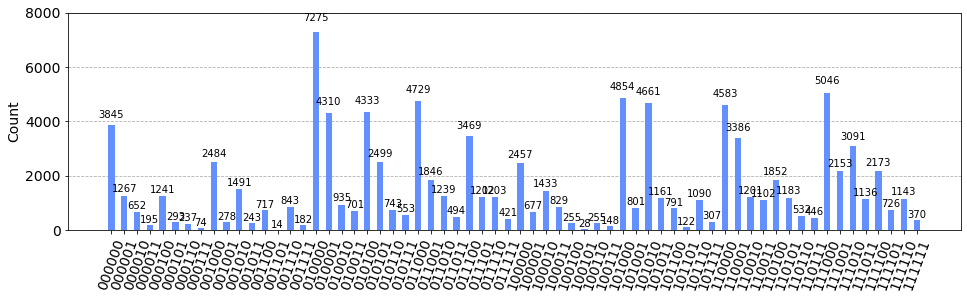

In [856]:
# 6 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

In [857]:
# 6 qubit
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

In [ ]:
print(times["rx"])
print(times["had"])

{3: [0.22300100326538086, 0.2390003204345703], 4: [0.2649989128112793, 0.2380352020263672], 5: [0.3020057678222656, 0.29900217056274414], 6: [0.45200300216674805, 0.3850076198577881]}
{3: [0.2160041332244873, 0.26298069953918457], 4: [0.2800142765045166, 0.2350316047668457], 5: [0.34296751022338867, 0.2539677619934082], 6: [0.31600213050842285, 0.3449714183807373]}


# Testing on IBM quantum computer

In [ ]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 7 and 
                                        not x.configuration().simulator and x.status().operational==True))
shots = backend.configuration().max_shots

backend_sim = Aer.get_backend('aer_simulator')

# Rx mixer

In [ ]:
# 3 qubit

gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend_sim)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["rx"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.564598652351576 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.789541808340072
Job Status: job is queued (14)    

KeyboardInterrupt: 

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 0.9999289612605513 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.999929618912359
Job Status: job has successfully run


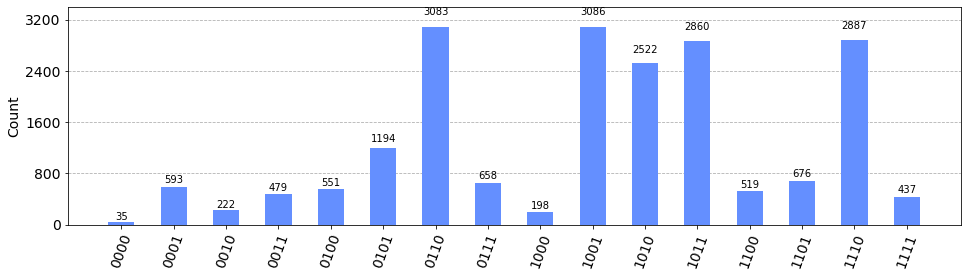

In [ ]:
# 4 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend_sim)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["rx"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: 1.0372909563938408 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: 0.40626328111330684
Job Status: job has successfully run


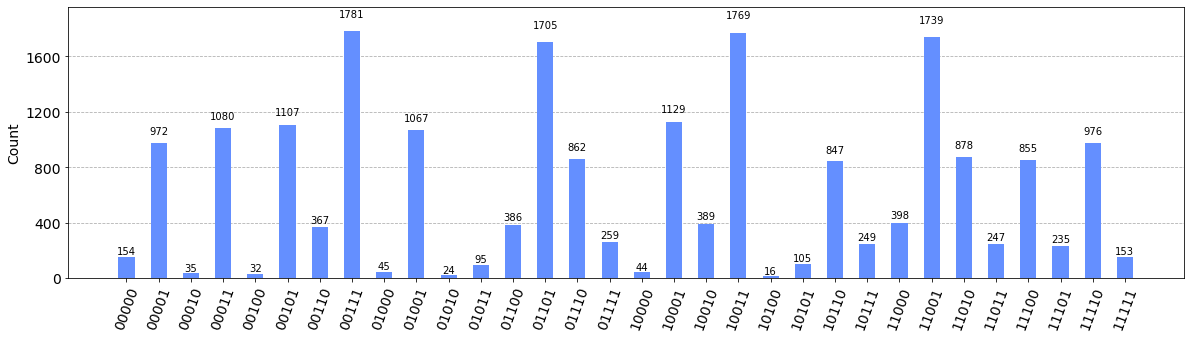

In [ ]:
# 5 qubit

gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation(g, backend_sim)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(20,5))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.9711469172191523 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.9445648802177575
Job Status: job has successfully run


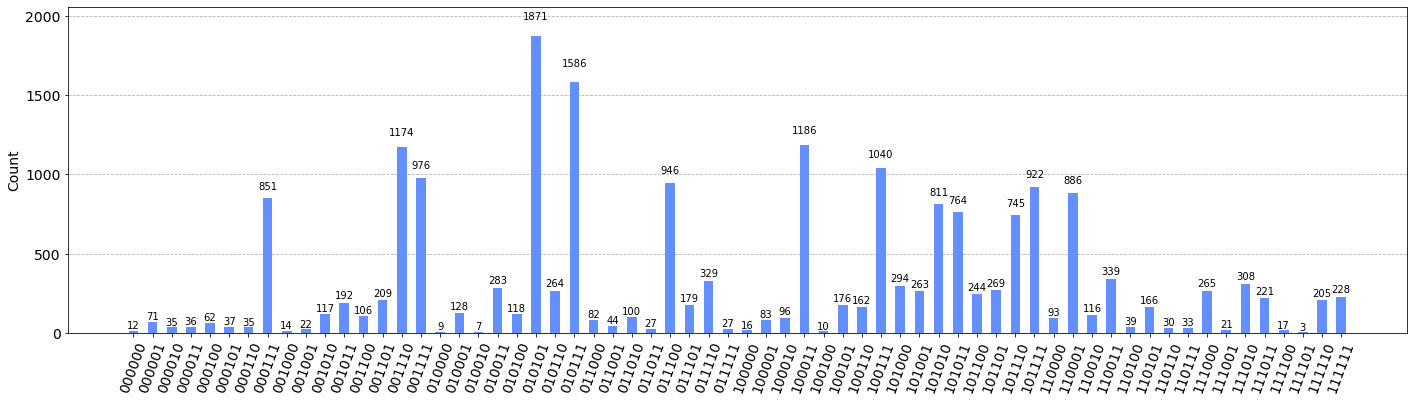

In [ ]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend_sim)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["rx"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(24,6))


# Hadamard Mixer

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 5.040962868006131 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 3.7098843306121783
Job Status: job has successfully run


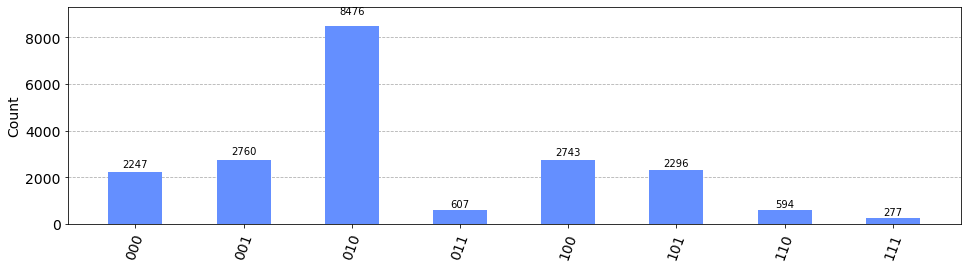

In [ ]:
# 3 qubit

gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation_had(g5, backend_sim)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["had"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))


Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.9964150295321466 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 0.6515785406326816
Job Status: job has successfully run


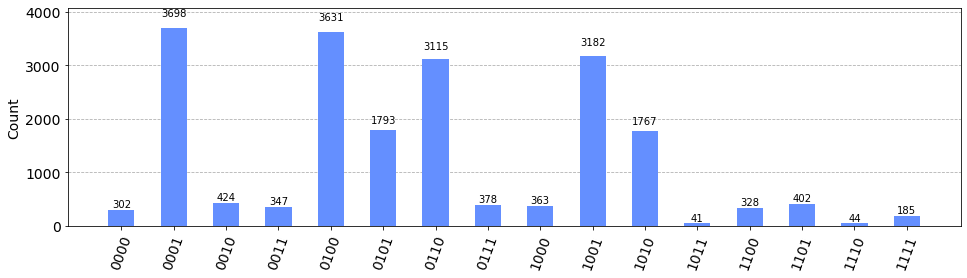

In [ ]:
# 4 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g3, backend_sim)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["had"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: 0.8754831399496938 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: 0.4971870578390832
Job Status: job has successfully run


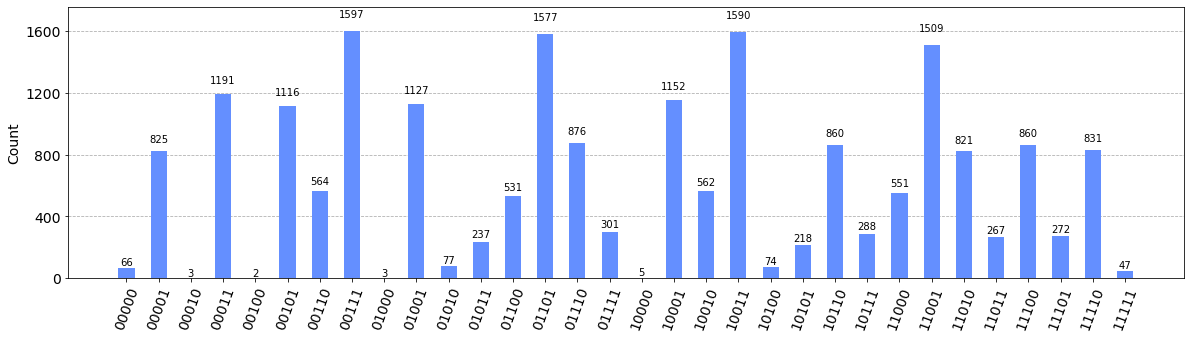

In [ ]:
# 5 qubit

gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation_had(g, backend_sim)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["had"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(20,5))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.0101017203463594 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 0.6155989900537262
Job Status: job has successfully run


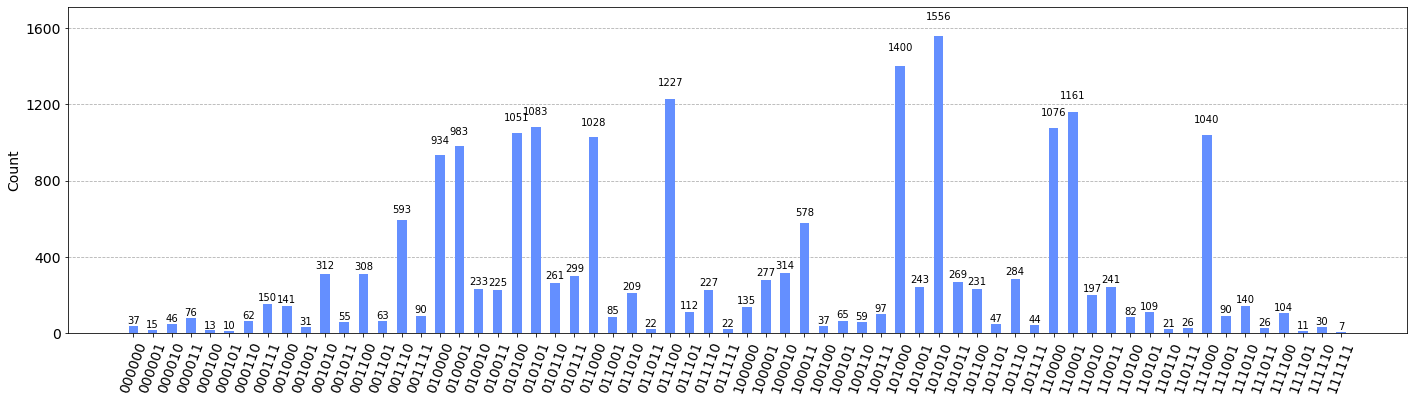

In [ ]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g4, backend_sim)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["had"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(24,6))

[Text(0, 0.5, 'Seconds taken to run circuit'), Text(0.5, 0, 'Qubit Count')]

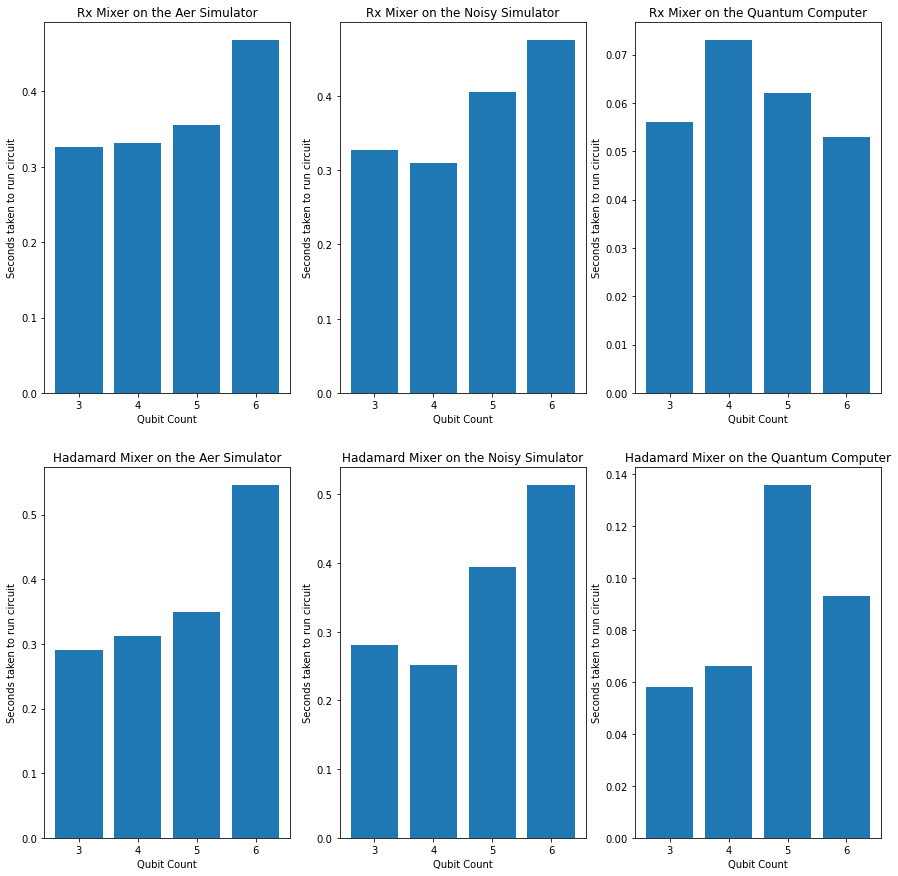

In [ ]:
qubits = [3,4,5,6]
    
rx_aer = []
rx_noisy = []
rx_qc = []

had_aer = []
had_noisy = []
had_qc = []

for i in range(4):
    rx_aer.append(times["rx"][i+3][0])
    rx_noisy.append(times["rx"][i+3][1])
    rx_qc.append(times["rx"][i+3][2])
    had_aer.append(times["had"][i+3][0])
    had_noisy.append(times["had"][i+3][1])
    had_qc.append(times["had"][i+3][2])

    
fig, axs = plt.subplots(2, 3, figsize=(15,15))
# rx aer
axs[0,0].bar(qubits, rx_aer)
axs[0,0].set_title("Rx Mixer on the Aer Simulator")
axs[0,0].set(ylabel='Seconds taken to run circuit', xlabel='Qubit Count')
# rx noisy
axs[0,1].bar(qubits, rx_noisy)
axs[0,1].set_title("Rx Mixer on the Noisy Simulator")
axs[0,1].set(ylabel='Seconds taken to run circuit', xlabel='Qubit Count')
# rx qc
axs[0,2].bar(qubits, rx_qc)
axs[0,2].set_title("Rx Mixer on the Quantum Computer")
axs[0,2].set(ylabel='Seconds taken to run circuit', xlabel='Qubit Count')

# Had aer
axs[1,0].bar(qubits, had_aer)
axs[1,0].set_title("Hadamard Mixer on the Aer Simulator")
axs[1,0].set(ylabel='Seconds taken to run circuit', xlabel='Qubit Count')
# had noisy
axs[1,1].bar(qubits, had_noisy)
axs[1,1].set_title("Hadamard Mixer on the Noisy Simulator")
axs[1,1].set(ylabel='Seconds taken to run circuit', xlabel='Qubit Count')
# had qc
axs[1,2].bar(qubits, had_qc)
axs[1,2].set_title("Hadamard Mixer on the Quantum Computer")
axs[1,2].set(ylabel='Seconds taken to run circuit', xlabel='Qubit Count')